
# 🧠 RAZR – Sistema de Alerta en Tiempo Real para la Detección de Somnolencia  
### *Implementación reproducible para entorno Jupyter Notebook (IEEE Q1 - Visión por Computador)*


In [1]:

# ===============================================================
# RAZR: Sistema de Alerta en Tiempo Real para la Detección de Somnolencia
# ===============================================================
# Implementación experimental del sistema descrito en:
# "Sistema de Detección de Somnolencia Basado en Visión por Computador
#  utilizando MediaPipe Face Mesh y Análisis del Eye Aspect Ratio (EAR)"
# Autor: Alejandro Seminario Medina
# Afiliación: Los Andes Labs
# Publicación: IEEE Q1 (Visión por Computador)
# ===============================================================

from scipy.spatial import distance as dist
from imutils.video import VideoStream
from collections import deque
import simpleaudio as sa
import mediapipe as mp
import matplotlib.pyplot as plt
import imutils
import cv2
import time
import numpy as np


In [2]:

class DetectorDeSomnolencia:
    """
    Sistema RAZR - Implementación experimental para entorno Jupyter.
    Evalúa el EAR (Eye Aspect Ratio) y emite una alerta acústica ante cierre ocular sostenido.
    """

    def __init__(self,
                 ruta_alarma: str,
                 indice_camara: int = 0,
                 umbral_ear: float = 0.18,
                 tiempo_umbral: float = 1.5,
                 texto_alerta: str = "ALERTA: SOMNOLENCIA",
                 duracion_alarma: int = 5,
                 ancho_frame: int = 450,
                 mostrar_grafico: bool = True,
                 mostrar_fps_origen: bool = False,
                 mostrar_fps_procesado: bool = False,
                 audio_activo: bool = True):
        # ---- Parámetros ----
        self.umbral_ear = umbral_ear
        self.tiempo_umbral = tiempo_umbral
        self.texto_alerta = texto_alerta
        self.duracion_alarma = duracion_alarma
        self.ancho_frame = ancho_frame
        self.mostrar_grafico = mostrar_grafico
        self.mostrar_fps_origen = mostrar_fps_origen
        self.mostrar_fps_procesado = mostrar_fps_procesado
        self.audio_activo = audio_activo
        self.ruta_alarma = ruta_alarma

        # ---- Variables internas ----
        self.alarma_activa = False
        self.tiempo_inicio = None
        self.inicio_alarma = None
        self.obj_audio = None
        self.historial_ear = deque()

        # ---- Landmarks ----
        self.indices_ojo_izq = [33, 160, 158, 133, 153, 144]
        self.indices_ojo_der = [362, 385, 387, 263, 373, 380]

        # ---- Inicialización MediaPipe ----
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

        # ---- Cámara ----
        self.vs = VideoStream(src=indice_camara).start()
        self.fps_origen = self._obtener_fps(indice_camara)

        if self.mostrar_grafico:
            self._inicializar_grafico()


    def _obtener_fps(self, indice_camara: int) -> int:
        cap = cv2.VideoCapture(indice_camara)
        fps = int(cap.get(cv2.CAP_PROP_FPS)) or 0
        cap.release()
        return fps

    def _inicializar_grafico(self):
        plt.ion()
        self.figura, self.ax = plt.subplots()
        self.linea_ear, = self.ax.plot([], [], 'b-', label='EAR')
        self.ax.axhline(y=self.umbral_ear, color='r', linestyle='--', label=f'Umbral ({self.umbral_ear})')
        self.ax.set(xlim=(0, 60), ylim=(0, 0.4),
                    xlabel="Tiempo (s, últimos 60 s)",
                    ylabel="EAR",
                    title="Evolución temporal del Eye Aspect Ratio (EAR)")
        self.ax.legend()
        plt.show(block=False)

    @staticmethod
    def _calcular_ear(ojo):
        A = dist.euclidean(ojo[1], ojo[5])
        B = dist.euclidean(ojo[2], ojo[4])
        C = dist.euclidean(ojo[0], ojo[3])
        return (A + B) / (2.0 * C)


    def _actualizar_grafico(self, ear: float):
        t_actual = time.time()
        self.historial_ear.append((t_actual, ear))
        while self.historial_ear and (t_actual - self.historial_ear[0][0]) > 60:
            self.historial_ear.popleft()

        if not self.mostrar_grafico:
            return

        tiempos_rel = [t - self.historial_ear[0][0] for t, _ in self.historial_ear]
        valores = [v for _, v in self.historial_ear]
        self.linea_ear.set_data(tiempos_rel, valores)
        self.ax.set_xlim(0, 60)
        self.figura.canvas.draw()
        self.figura.canvas.flush_events()

    def _activar_alarma(self):
        if not self.audio_activo or self.alarma_activa:
            return
        try:
            self.obj_audio = sa.WaveObject.from_wave_file(self.ruta_alarma).play()
            self.inicio_alarma = time.time()
            self.alarma_activa = True
        except Exception:
            self.alarma_activa = False

    def _gestionar_audio(self):
        if not self.alarma_activa or not self.obj_audio:
            return
        if (time.time() - self.inicio_alarma) >= self.duracion_alarma or not self.obj_audio.is_playing():
            try:
                self.obj_audio.stop()
            except Exception:
                pass
            self.alarma_activa = False
            self.obj_audio = None


    def _procesar_frame(self, frame):
        resultados = self.face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not resultados.multi_face_landmarks:
            self._gestionar_audio()
            return frame

        h, w = frame.shape[:2]
        for landmarks in resultados.multi_face_landmarks:
            ojo_izq = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h))
                       for i in self.indices_ojo_izq]
            ojo_der = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h))
                       for i in self.indices_ojo_der]

            ear = (self._calcular_ear(ojo_izq) + self._calcular_ear(ojo_der)) / 2.0
            self._actualizar_grafico(ear)

            cv2.polylines(frame, [cv2.convexHull(np.array(ojo_izq))], True, (255, 0, 0), 1)
            cv2.polylines(frame, [cv2.convexHull(np.array(ojo_der))], True, (255, 0, 0), 1)

            if ear < self.umbral_ear:
                if self.tiempo_inicio is None:
                    self.tiempo_inicio = time.time()
                elif (time.time() - self.tiempo_inicio) >= self.tiempo_umbral:
                    self._activar_alarma()
                    cv2.putText(frame, self.texto_alerta, (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            else:
                self.tiempo_inicio = None

            cv2.putText(frame, f"EAR: {ear:.2f}", (300, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        self._gestionar_audio()
        return frame


    def ejecutar(self):
        tiempo_previo = time.time()
        try:
            while True:
                frame = imutils.resize(self.vs.read(), width=self.ancho_frame)
                frame = self._procesar_frame(frame)
                if self.mostrar_fps_origen and self.fps_origen > 0:
                    cv2.putText(frame, f"FPS Origen: {self.fps_origen}", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                if self.mostrar_fps_procesado:
                    tiempo_actual = time.time()
                    fps_proc = 1.0 / (tiempo_actual - tiempo_previo)
                    tiempo_previo = tiempo_actual
                    cv2.putText(frame, f"FPS Proc: {fps_proc:.2f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
                cv2.imshow("RAZR - Detector de Somnolencia", frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
        finally:
            self._liberar_recursos()

    def _liberar_recursos(self):
        cv2.destroyAllWindows()
        plt.close('all')
        self.vs.stop()
        self.face_mesh.close()

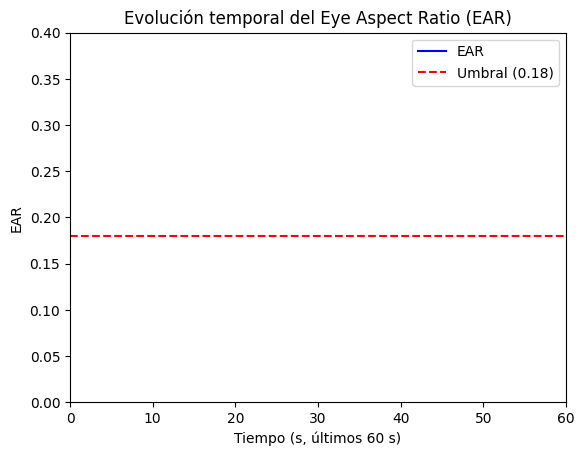

In [3]:

detector = DetectorDeSomnolencia(
    ruta_alarma="alarma.wav",
    indice_camara=0,
    umbral_ear=0.18,
    tiempo_umbral=1.0,
    duracion_alarma=5,
    texto_alerta="ALERTA: SOMNOLENCIA",
    mostrar_fps_origen=True,
    mostrar_fps_procesado=True,
    mostrar_grafico=True
)

detector.ejecutar()

In [4]:

try:
    detector._liberar_recursos()
except Exception:
    pass
